In [2]:
import sys
import os

# Add the project root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import importlib

In [3]:

import src.data.preprocess as preprocess
importlib.reload(preprocess)

from src.data.load_data import load_trip_data, load_data_reports_monthly, load_taxi_zones
from src.data.preprocess import preprocess_trip_data

# loading and preprocessing trip data
df = load_trip_data('../data/raw/fhvhv_tripdata_2025-02.parquet')
trip_data = preprocess_trip_data(df)

# loading taxi zones
taxi_zones = load_taxi_zones('../data/raw/taxi_zones/taxi_zones.shp')

# loading monthly data reports
data_reports_monthly = load_data_reports_monthly('../data/raw/data_reports_monthly.csv')

# Inferring the Fleet Size

## Approach Zero
In the monthly data reports were given the total number of 
To estimate the average fleet size of Uber and Lyft per day, take the percentage of Uber rides among all rides and apply that proportion to the total vehicle count per day.

In [ ]:
# show line where Month/Year is '2025-02' and License Class is 'FHV - High Volume'
feb_2025 = data_reports_monthly[data_reports_monthly['Month/Year'] == '2025-02']
feb_2025 = feb_2025[feb_2025['License Class'] == 'FHV - High Volume']

print("Total High Volume For Hire Vehicle Fleet Size in February 2025 (Drivers): " + feb_2025['Unique Drivers'].astype(str).values[0])
print("Total High Volume For Hire Vehicle Fleet Size in February 2025 (Vehicles): " + feb_2025['Unique Vehicles'].astype(str).values[0])

# portion of rides that are Uber
uber_rides_count = len(trip_data[trip_data['company'] == 'Uber'])
uber_rides_share = uber_rides_count / len(trip_data)

# Apply share to total ride hailing fleet size
# Remove commas from the string before converting to float
vehicles_per_day_str = feb_2025['Vehicles Per Day'].iloc[0].replace(',', '')
uber_fleet_size = float(vehicles_per_day_str) * uber_rides_share

print("Estimated Lyft Fleet Size in February 2025: " + str(int(vehicles_per_day_str) - int(uber_fleet_size)))
print("Estimated Uber Fleet Size in February 2025: " + str(int(uber_fleet_size)))

print("Average Daily Rides in February 2025: " + str(len(trip_data)/28))

feb_2025

Fleet Size in February 2025 (Drivers): 80,286
Fleet Size in February 2025 (Vehicles): 79,556
Estimated Lyft Fleet Size in February 2025: 14622
Estimated Uber Fleet Size in February 2025: 42855
Average Daily Rides in February 2025: 690695.0357142857


,Month/Year,License Class,Trips Per Day,Farebox Per Day,Unique Drivers,Unique Vehicles,Vehicles Per Day,Avg Days Vehicles on Road,Avg Hours Per Day Per Vehicle,Avg Days Drivers on Road,Avg Hours Per Day Per Driver,Avg Minutes Per Trip,Percent of Trips Paid with Credit Card,Trips Per Day Shared
10,2025-02,FHV - High Volume,"690,694",-,"80,286","79,556","57,477",20.2,6.6,20.3,6.5,18.0,-,"13,562"


### First Approach
For each minute calculate the amount of active rides. The maximum amount of simultanous rides can be a lower bound for the fleet size of the day.

Lyft max active rides: 4285
Lyft average active rides: 2519.65
Uber max active rides: 12881
Uber average active rides: 7562.19


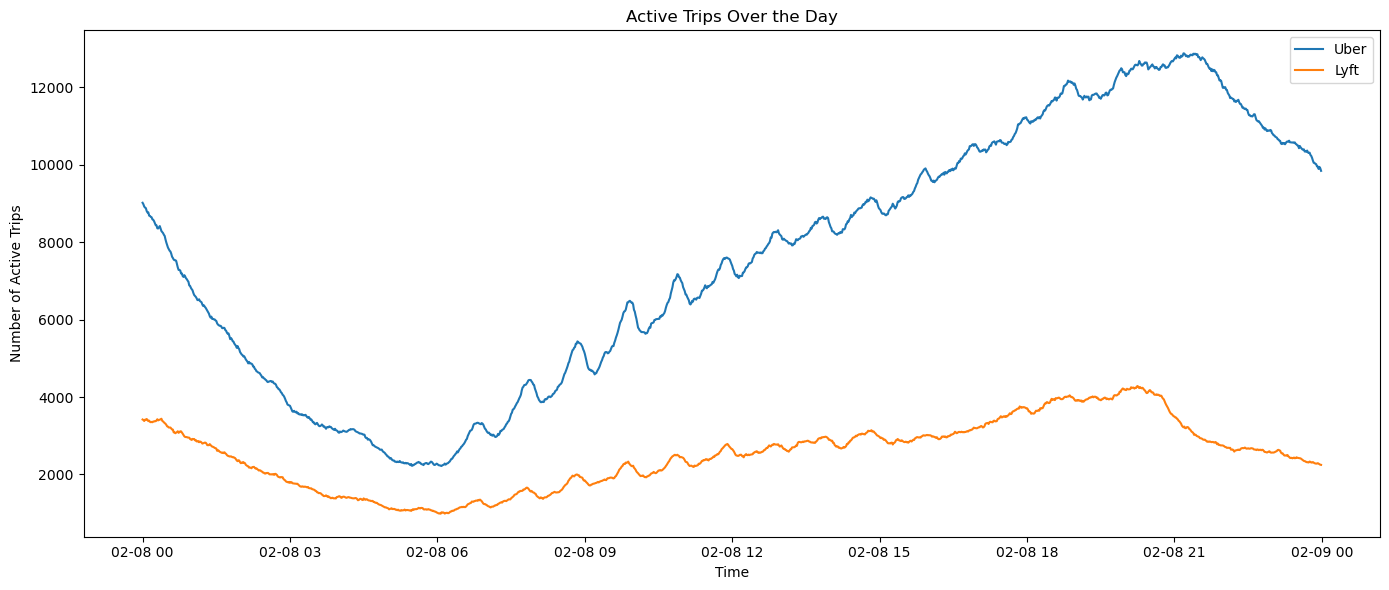

In [5]:
import importlib

import src.fleet_size.active_trips as active_trips
importlib.reload(active_trips)
from src.fleet_size.active_trips import analyze_active_rides_by_company, plot_active_trips_over_day

feb2_active_rides = analyze_active_rides_by_company(trip_data, target_date='2025-02-08')

# Print max rides for Uber and Lyft on that day
lyft_rides = feb2_active_rides.get('Lyft')
if lyft_rides is not None:
    max_active = lyft_rides['active_rides'].max()
    avg_active = lyft_rides['active_rides'].mean()
    print(f"Lyft max active rides: {max_active}")
    print(f"Lyft average active rides: {avg_active:.2f}")

uber_rides = feb2_active_rides.get('Uber')
if uber_rides is not None:
    max_active = uber_rides['active_rides'].max()
    avg_active = uber_rides['active_rides'].mean()
    print(f"Uber max active rides: {max_active}")
    print(f"Uber average active rides: {avg_active:.2f}")

plot_active_trips_over_day(feb2_active_rides)

/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/active_trips.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['pickup_datetime'].dt.date


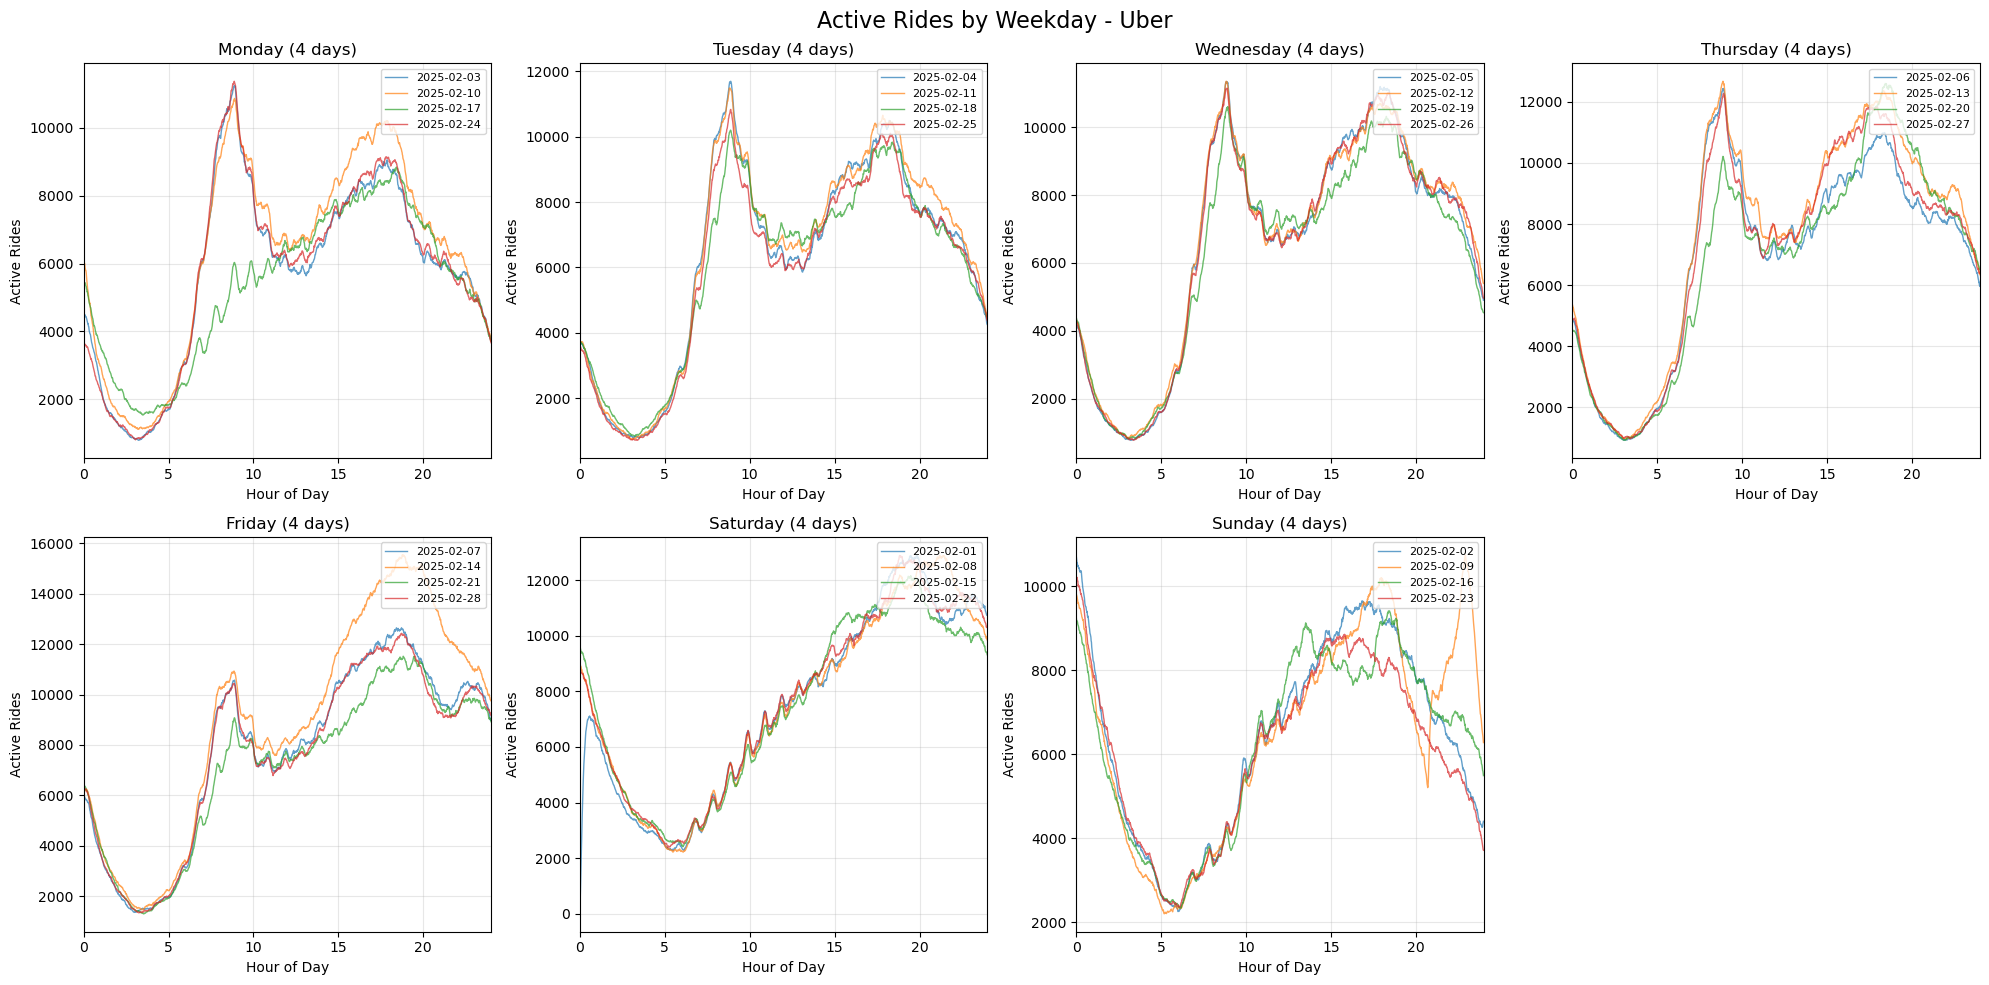

In [6]:
import importlib

import src.fleet_size.active_trips as active_trips
importlib.reload(active_trips)
from src.fleet_size.active_trips import plot_active_trips_by_weekday


plot_active_trips_by_weekday(trip_data, company='Uber')

/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/active_trips.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['pickup_datetime'].dt.date


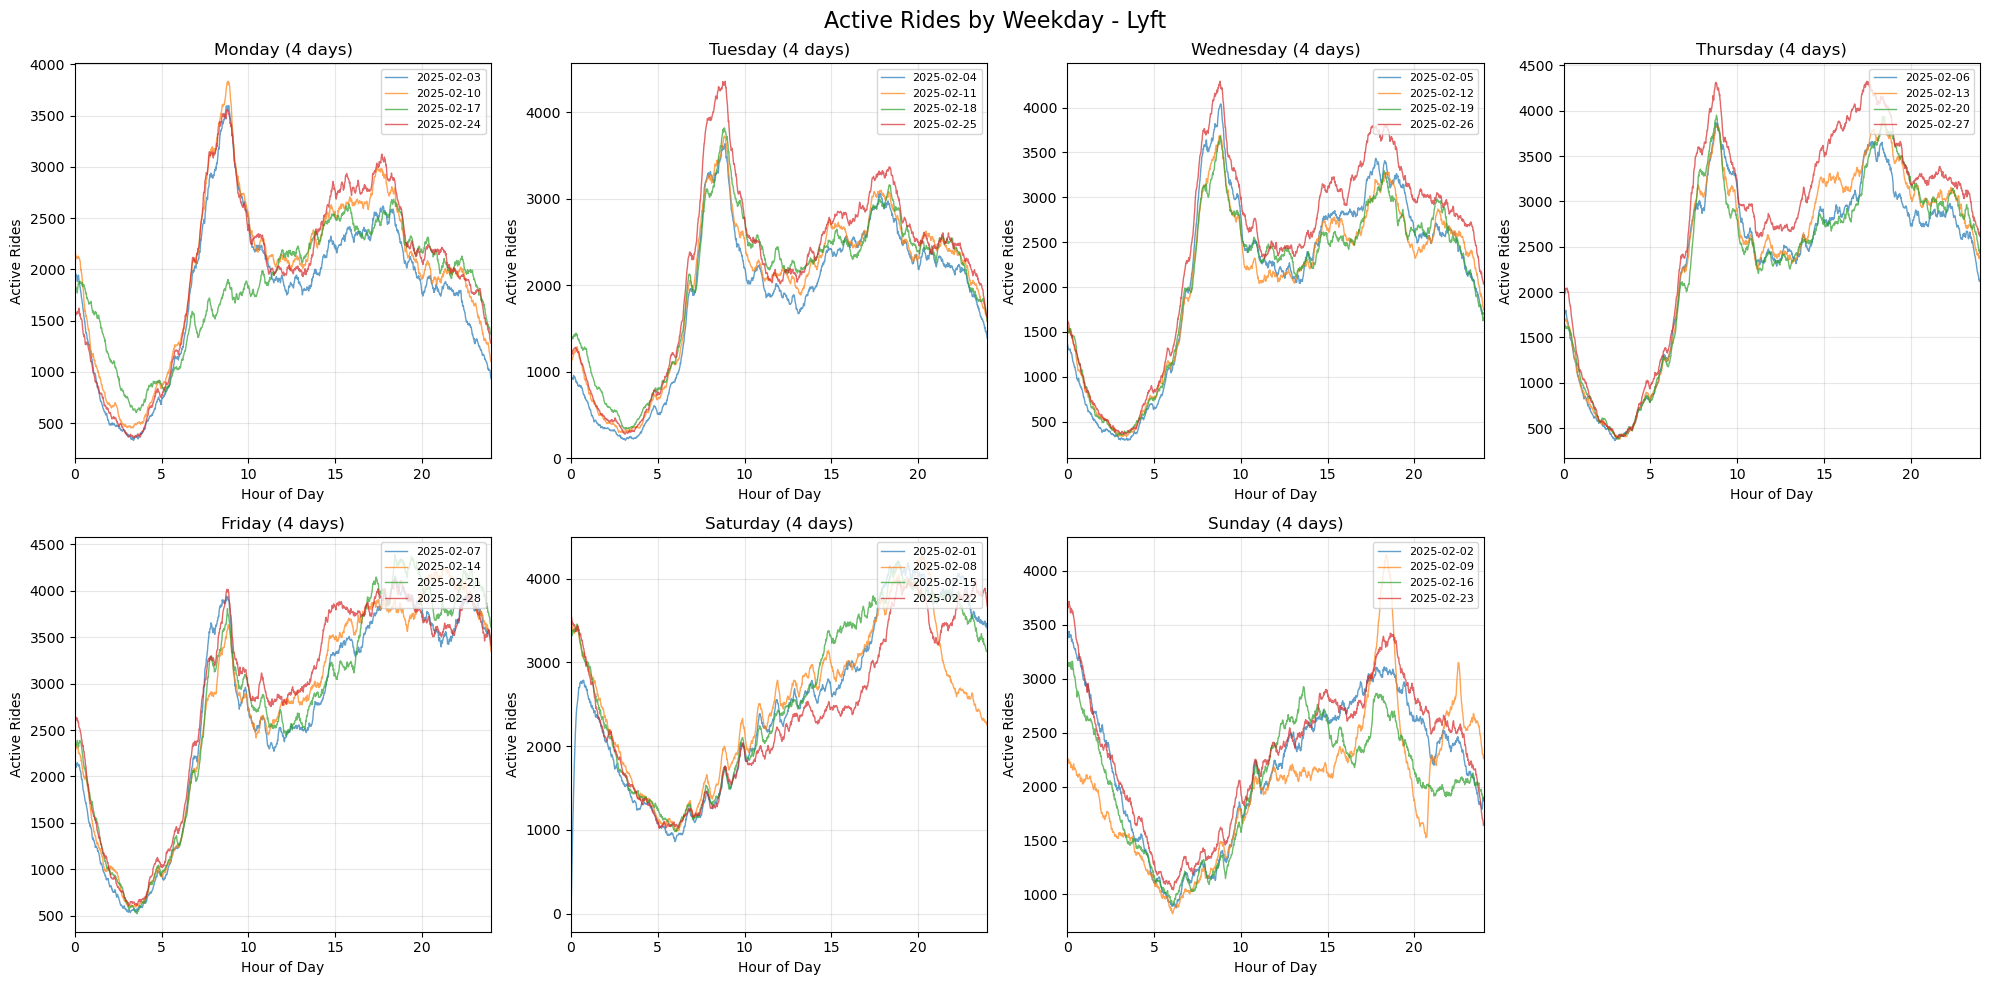

In [7]:
plot_active_trips_by_weekday(trip_data, company='Lyft')

## Second Approach

Calculate the minimum fleet size by linking possible trips together and count the mininal amount of drivers needed 

### Step 1: Zone-Time Matrix

In [4]:
import importlib
import pandas as pd

import src.fleet_size.zone_time_matrix as zone_time_matrix
importlib.reload(zone_time_matrix)
from src.fleet_size.zone_time_matrix import create_zone_explorer_widget, calculate_zone_time_matrix

matrix = calculate_zone_time_matrix(trip_data)

# DOES NOT WORK YET TODO
# matrix = pd.read_csv('../data/processed/zone_time_matrix_new.csv')

# create_zone_explorer_widget(matrix, taxi_zones)



Valid trips: 19335169


/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/zone_time_matrix.py:24: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  avg_df = valid_trips.groupby(['PULocationID', 'DOLocationID'], as_index=False)['trip_time'].agg({


Direct zone connections found: 59019 out of 67081 possible pairs
Total zones: 263
Calculating shortest paths...
Total intra-zone trips found: 1472959
Zones with intra-zone trips: 256
Zones without intra-zone trips: 7
Example zones without intra-zone trips: [1, 2, 12, 105, 110, 199, 264]
Overall average intra-zone trip time: 486.9 seconds (8.1 minutes)
Travel time statistics:
  Mean: 2095.4 seconds
  Median: 2089.3 seconds
  Max: 6702.9 seconds
  Connections with data: 68906 / 69169


## Lyft fleetsize 

In [6]:
import src.fleet_size.link_sequential_trips as link_sequential_trips
importlib.reload(link_sequential_trips)

# only use Lyft trips
lyft_trip_data = trip_data[trip_data['company'] == 'Lyft']

# only use trips from February 2nd 10am to noon 2025
lyft_trip_data_short = lyft_trip_data[(lyft_trip_data['pickup_datetime'] >= pd.to_datetime('2025-02-02 10:00:00')) &
                                  (lyft_trip_data['pickup_datetime'] <= pd.to_datetime('2025-02-02 12:00:00'))]

print("Number of Lyft trips: " + str(len(lyft_trip_data)))
print("Number of Lyft trips on 2nd February 2025 between 10am and noon: " + str(len(lyft_trip_data_short)))

print(link_sequential_trips.calculate_minimum_drivers_vectorized(lyft_trip_data_short, matrix))
print(link_sequential_trips.calculate_minimum_drivers_improved(lyft_trip_data_short, matrix))

Number of Lyft trips: 4919838
Number of Lyft trips on 2nd February 2025 between 10am and noon: 16072
3706
3706


Number of Lyft trips: 4919838
Number of Lyft trips on 25th February: 160659
6481
6481
9815
9815


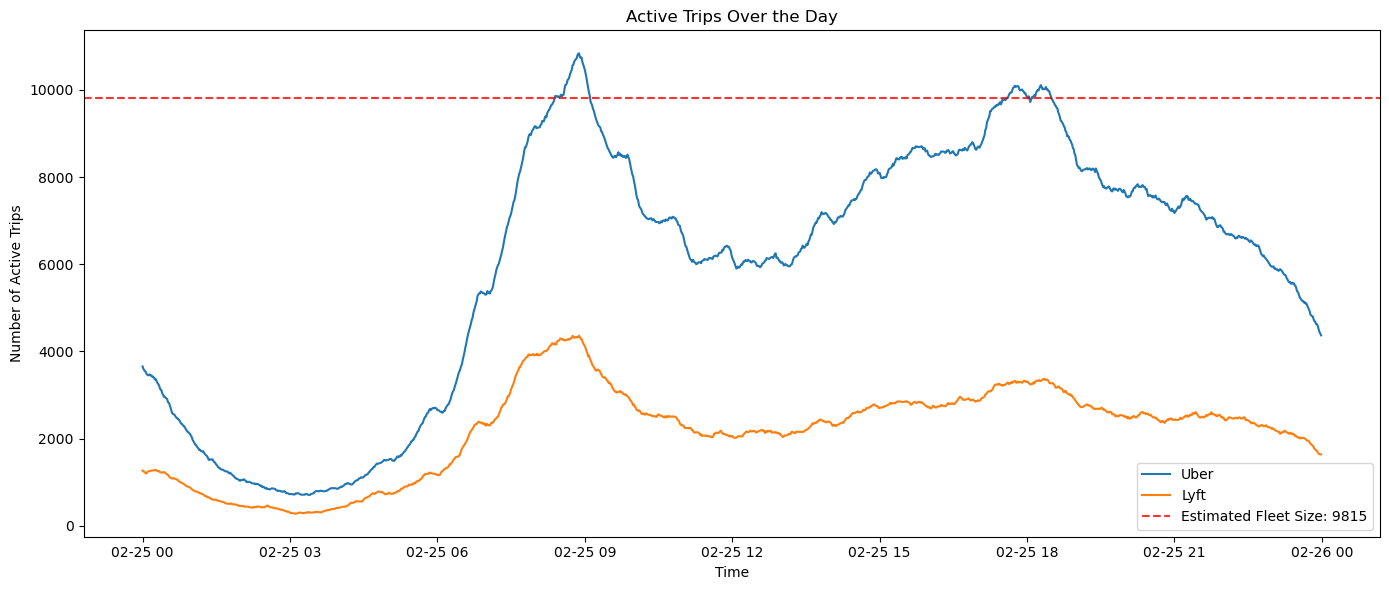

In [10]:
import src.fleet_size.link_sequential_trips as link_sequential_trips
importlib.reload(link_sequential_trips)

import src.fleet_size.active_trips as active_trips
importlib.reload(active_trips)
from src.fleet_size.active_trips import analyze_active_rides_by_company, plot_active_trips_over_day


# only use Lyft trips
lyft_trip_data = trip_data[trip_data['company'] == 'Lyft']

# only use trips from February 25th
lyft_trip_data_short = lyft_trip_data[(lyft_trip_data['pickup_datetime'] >= pd.to_datetime('2025-02-25 00:00:00')) &
                                  (lyft_trip_data['pickup_datetime'] <= pd.to_datetime('2025-02-26 00:00:00'))]

print("Number of Lyft trips: " + str(len(lyft_trip_data)))
print("Number of Lyft trips on 25th February: " + str(len(lyft_trip_data_short)))

estimated_fleet_size = link_sequential_trips.calculate_minimum_drivers_vectorized(lyft_trip_data_short, matrix)
print(estimated_fleet_size)

estimated_fleet_size_improved = link_sequential_trips.calculate_minimum_drivers_improved(lyft_trip_data_short, matrix)
print(estimated_fleet_size_improved)

active_rides = analyze_active_rides_by_company(trip_data, target_date='2025-02-25')
plot_active_trips_over_day(active_rides, estimated_fleet_size=estimated_fleet_size_improved)

In [4]:
import src.fleet_size.link_sequential_trips as link_sequential_trips
importlib.reload(link_sequential_trips)

# only use Lyft trips
lyft_trip_data = trip_data[trip_data['company'] == 'Lyft']

lyft_fleet_size_summary = link_sequential_trips.create_fleet_size_summary_table(lyft_trip_data, matrix)
lyft_fleet_size_summary

Processing 2025-02-01...
Finished processing 2025-02-01.
Processing 2025-02-02...
Finished processing 2025-02-02.
Processing 2025-02-03...
Finished processing 2025-02-03.
Processing 2025-02-04...
Finished processing 2025-02-04.
Processing 2025-02-05...
Finished processing 2025-02-05.
Processing 2025-02-06...
Finished processing 2025-02-06.
Processing 2025-02-07...
Finished processing 2025-02-07.
Processing 2025-02-08...
Finished processing 2025-02-08.
Processing 2025-02-09...
Finished processing 2025-02-09.
Processing 2025-02-10...
Finished processing 2025-02-10.
Processing 2025-02-11...
Finished processing 2025-02-11.
Processing 2025-02-12...
Finished processing 2025-02-12.
Processing 2025-02-13...
Finished processing 2025-02-13.
Processing 2025-02-14...
Finished processing 2025-02-14.
Processing 2025-02-15...
Finished processing 2025-02-15.
Processing 2025-02-16...
Finished processing 2025-02-16.
Processing 2025-02-17...
Finished processing 2025-02-17.
Processing 2025-02-18...
Finish

,date,Fleet_Size_Full_Day,Fleet_Size_Peak_Morning,Fleet_Size_Peak_Evening,Fleet_Size_Off_Peak,weekday
0,2025-02-01,6498,3347,6393,4823,Saturday
1,2025-02-02,5046,3046,4847,4594,Sunday
2,2025-02-03,5376,5376,4111,3821,Monday
3,2025-02-04,5348,5341,4653,4064,Tuesday
4,2025-02-05,6039,6034,5256,4523,Wednesday
5,2025-02-06,5887,5830,5693,4873,Thursday
6,2025-02-07,6564,6062,6390,5480,Friday
7,2025-02-08,6501,3661,6295,4910,Saturday
8,2025-02-09,6556,2931,6540,4093,Sunday
9,2025-02-10,5647,5646,4331,4163,Monday


Generating fleet size visualizations...
1. Fleet Size Trends Over Time


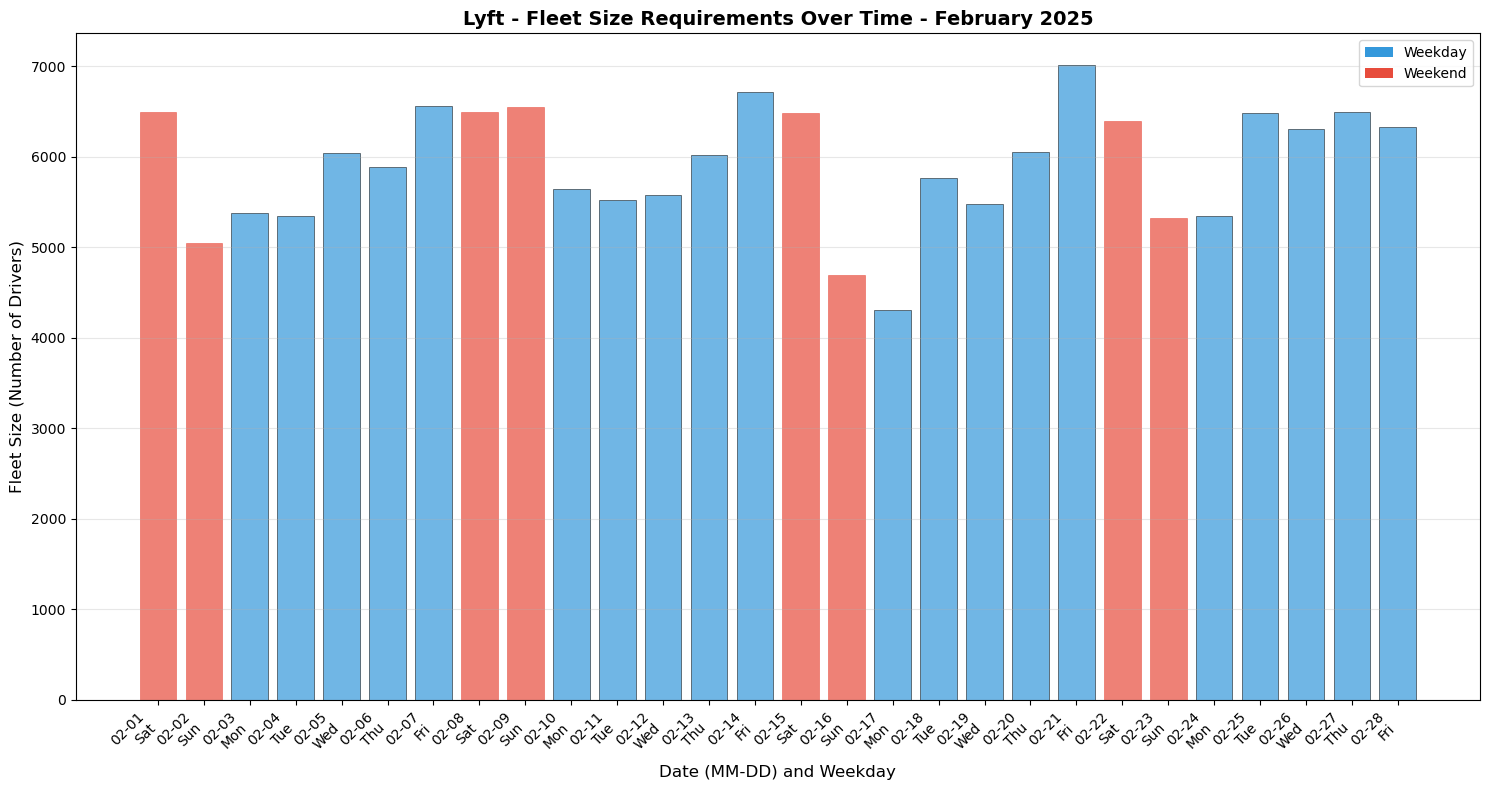

2. Weekday Time Period Comparison


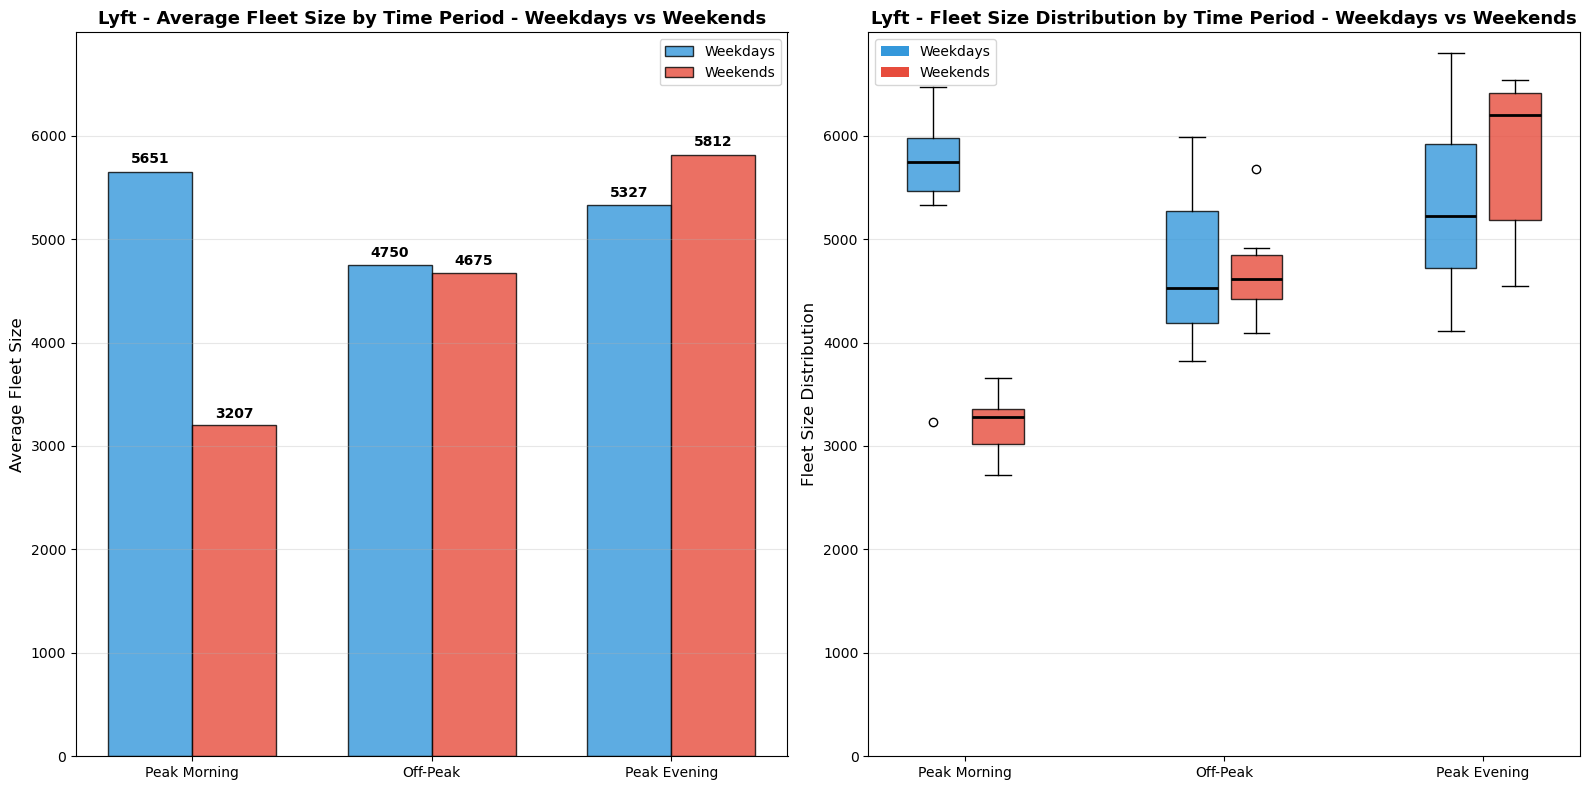

3. Weekday Patterns Analysis


/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/visualizations.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/visualizations.py:203: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/visualizations.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

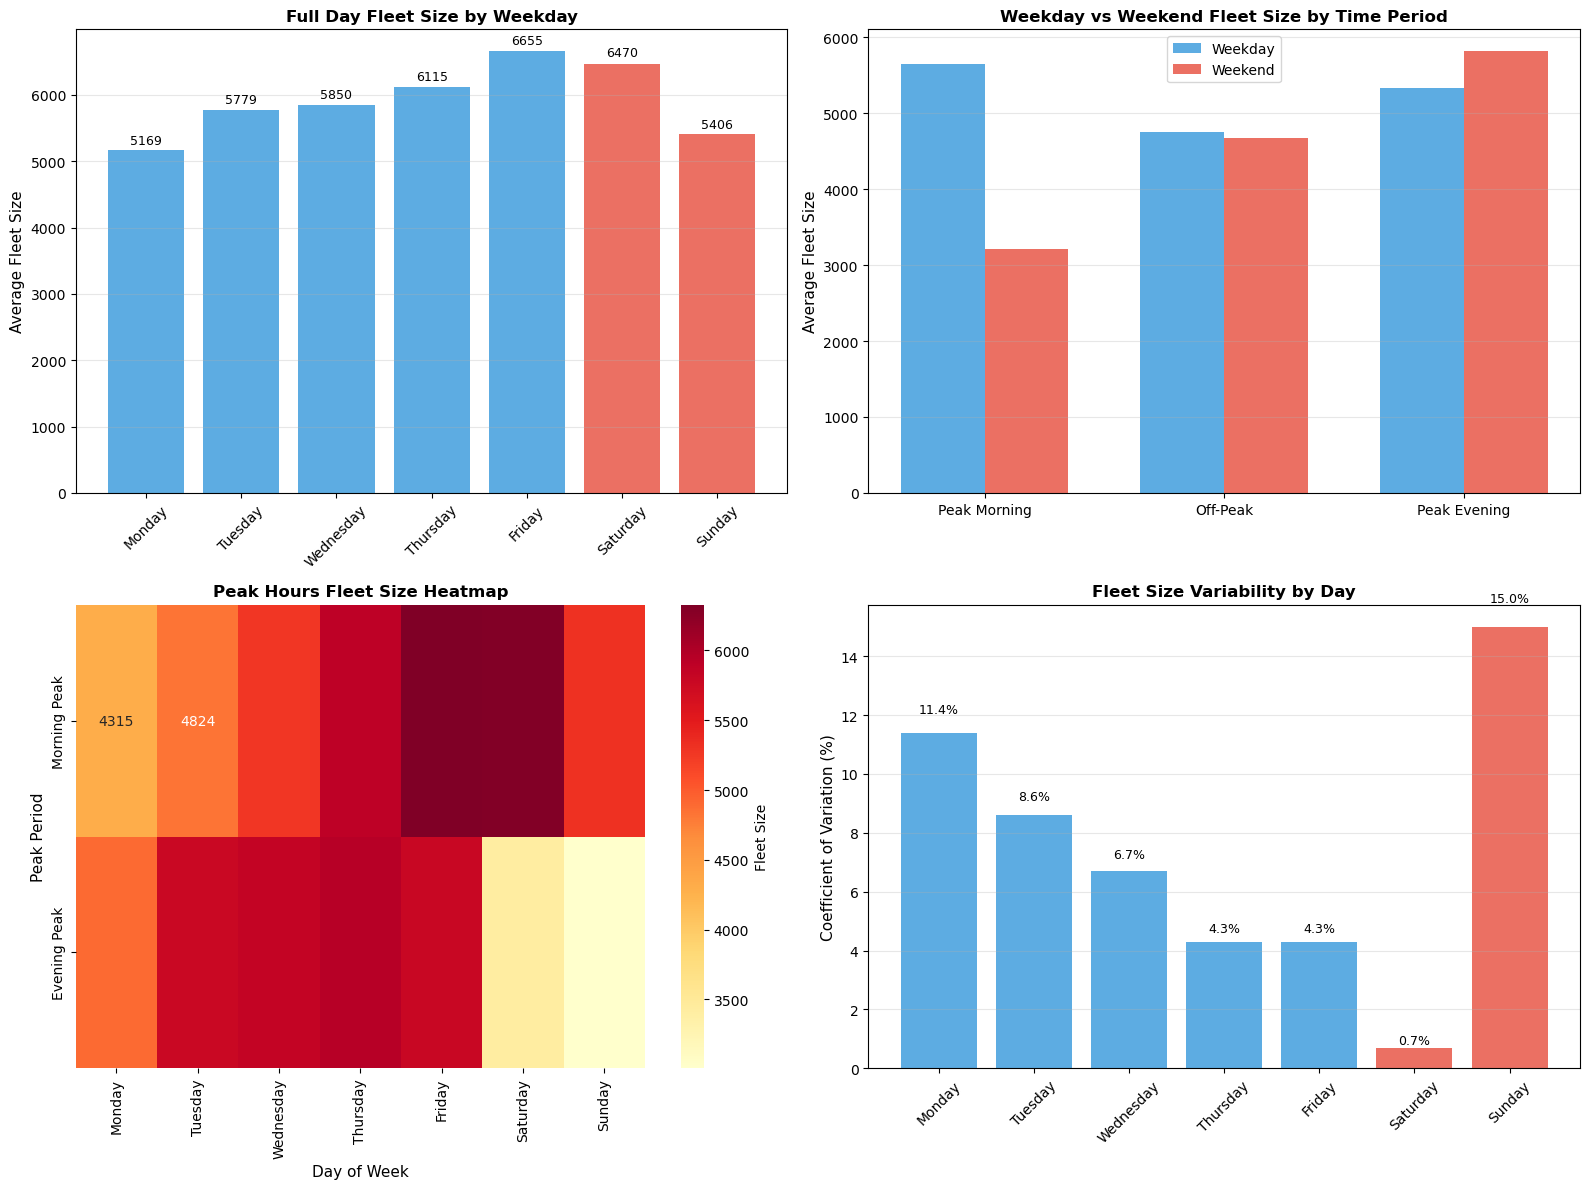

In [20]:
import pandas as pd
import src.fleet_size.visualizations as visualizations
importlib.reload(visualizations)


visualizations.visualize_fleet_size_summary(pd.read_csv('../data/processed/lyft_fleet_size_summary.csv'))

In [14]:
lyft_summary = pd.read_csv('../data/processed/lyft_fleet_size_summary.csv')

print(lyft_summary['Fleet_Size_Peak_Evening'].mean())
print(lyft_summary['Fleet_Size_Peak_Evening'].max())
print(lyft_summary['Fleet_Size_Peak_Evening'].min())

5465.285714285715
6795
4111


## Uber fleetsize

In [ ]:
import src.fleet_size.link_sequential_trips as link_sequential_trips
importlib.reload(link_sequential_trips)

# only use Uber trips
uber_trip_data = trip_data[trip_data['company'] == 'Uber']

# only use trips from February 8nd
uber_trip_data_short = uber_trip_data[(uber_trip_data['pickup_datetime'] >= pd.to_datetime('2025-02-08 00:00:00')) &
                                  (uber_trip_data['pickup_datetime'] <= pd.to_datetime('2025-02-09 00:00:00'))]

print("Number of Uber trips on 8nd February: " + str(len(uber_trip_data_short)))

link_sequential_trips.calculate_minimum_drivers_vectorized(uber_trip_data_short, matrix)

Number of Uber trips on 8nd February: 578945
Processed 1 trips, current driver count: 1, 
Processed 1001 trips, current driver count: 1001, 
Processed 2001 trips, current driver count: 2001, 
Processed 3001 trips, current driver count: 3001, 
Processed 4001 trips, current driver count: 4001, 
Processed 5001 trips, current driver count: 4997, 
Processed 6001 trips, current driver count: 5962, 
Processed 7001 trips, current driver count: 6872, 
Processed 8001 trips, current driver count: 7693, 
Processed 9001 trips, current driver count: 8415, 
Processed 10001 trips, current driver count: 9019, 
Processed 11001 trips, current driver count: 9479, 
Processed 12001 trips, current driver count: 9894, 
Processed 13001 trips, current driver count: 10187, 
Processed 14001 trips, current driver count: 10407, 
Processed 15001 trips, current driver count: 10623, 
Processed 16001 trips, current driver count: 10779, 
Processed 17001 trips, current driver count: 10917, 
Processed 18001 trips, current

18732

In [ ]:
import src.fleet_size.link_sequential_trips as link_sequential_trips
importlib.reload(link_sequential_trips)

# only use Uber trips
uber_trip_data = trip_data[trip_data['company'] == 'Uber']

uber_fleet_size_summary = link_sequential_trips.create_fleet_size_summary_table(uber_trip_data, matrix)
uber_fleet_size_summary.to_csv('../data/processed/uber_fleet_size_summary.csv', index=False)
uber_fleet_size_summary

Processing 2025-02-01...
Finished processing 2025-02-01.
Processing 2025-02-02...
Finished processing 2025-02-02.
Processing 2025-02-03...
Finished processing 2025-02-03.
Processing 2025-02-04...
Finished processing 2025-02-04.
Processing 2025-02-05...
Finished processing 2025-02-05.
Processing 2025-02-06...
Finished processing 2025-02-06.
Processing 2025-02-07...
Finished processing 2025-02-07.
Processing 2025-02-08...
Finished processing 2025-02-08.
Processing 2025-02-09...
Finished processing 2025-02-09.
Processing 2025-02-10...
Finished processing 2025-02-10.
Processing 2025-02-11...
Finished processing 2025-02-11.
Processing 2025-02-12...
Finished processing 2025-02-12.
Processing 2025-02-13...
Finished processing 2025-02-13.
Processing 2025-02-14...
Finished processing 2025-02-14.
Processing 2025-02-15...
Finished processing 2025-02-15.
Processing 2025-02-16...
Finished processing 2025-02-16.
Processing 2025-02-17...
Finished processing 2025-02-17.
Processing 2025-02-18...
Finish

,date,Fleet_Size_Full_Day,Fleet_Size_Peak_Morning,Fleet_Size_Peak_Evening,Fleet_Size_Off_Peak,weekday
0,2025-02-01,19394,10151,19322,15593,Saturday
1,2025-02-02,15024,9510,14109,14873,Sunday
2,2025-02-03,16202,16193,13336,12618,Monday
3,2025-02-04,16686,16677,15692,14052,Tuesday
4,2025-02-05,17360,16617,16760,15221,Wednesday
5,2025-02-06,18222,18198,16936,15333,Thursday
6,2025-02-07,19028,15670,18845,16858,Friday
7,2025-02-08,18731,10087,18330,15651,Saturday
8,2025-02-09,16141,8691,15517,14748,Sunday
9,2025-02-10,15892,15881,14936,14316,Monday


Generating fleet size visualizations...
1. Fleet Size Trends Over Time


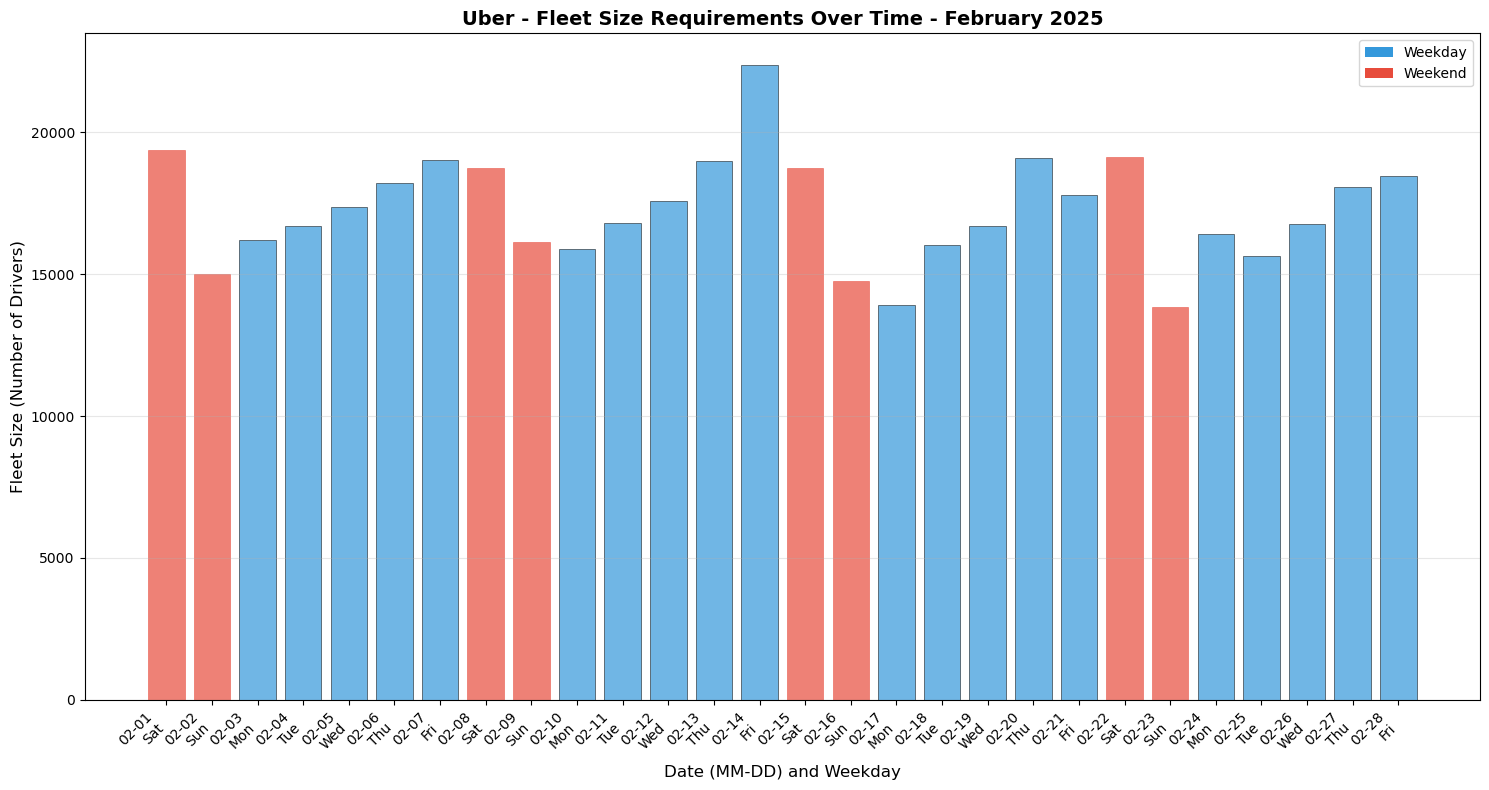

2. Weekday Time Period Comparison


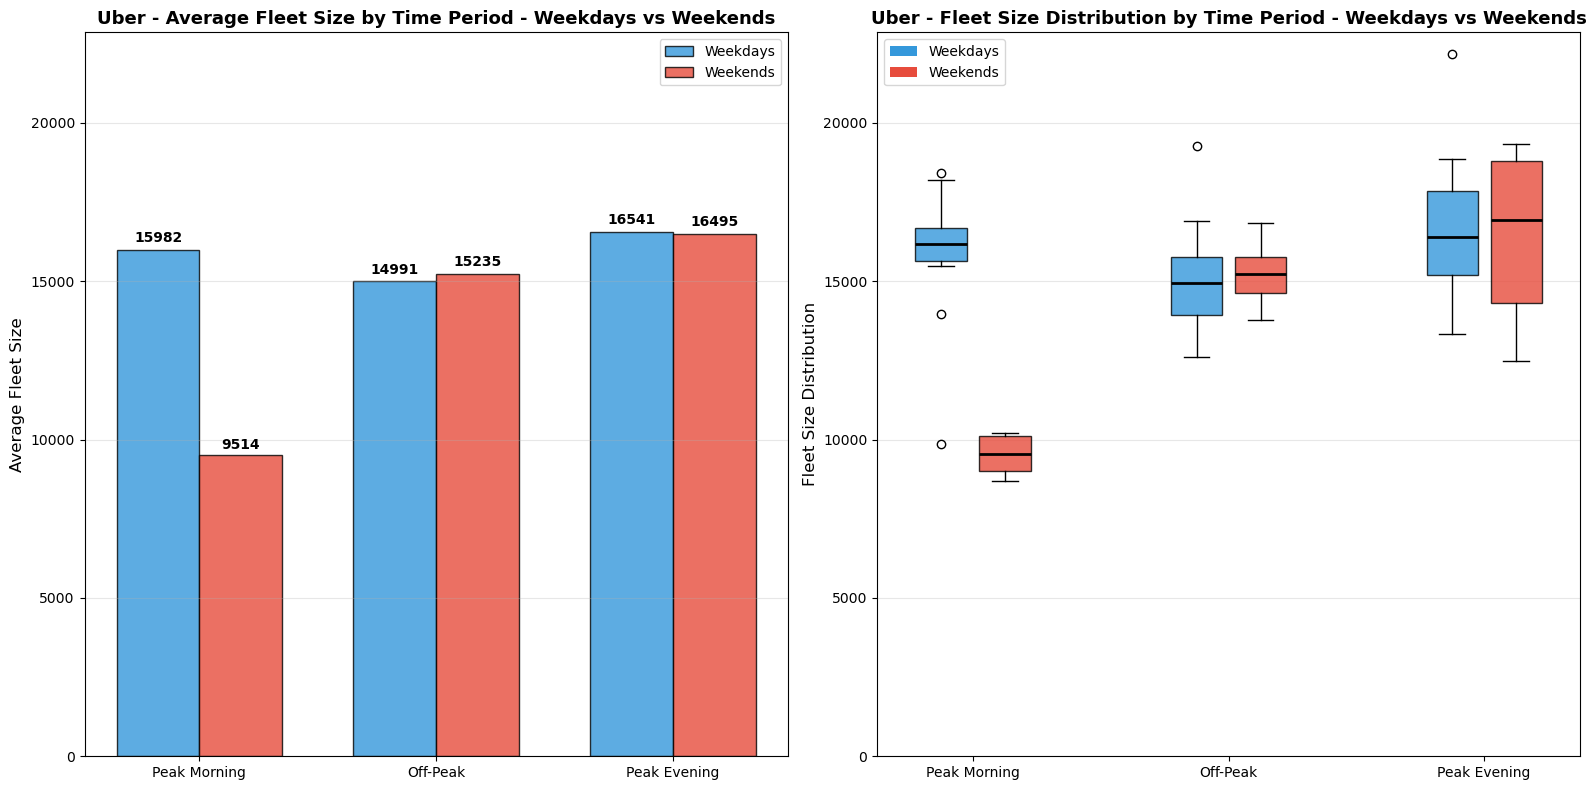

3. Weekday Patterns Analysis


/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/visualizations.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_avg = df_viz.groupby('weekday')['Fleet_Size_Full_Day'].mean()
/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/visualizations.py:203: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  peak_data = df_viz.pivot_table(
/Users/hendrik/Desktop/Uni/6 Semester/Bachelorarbeit/Thesis_HME/Code/src/fleet_size/visualizations.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observ

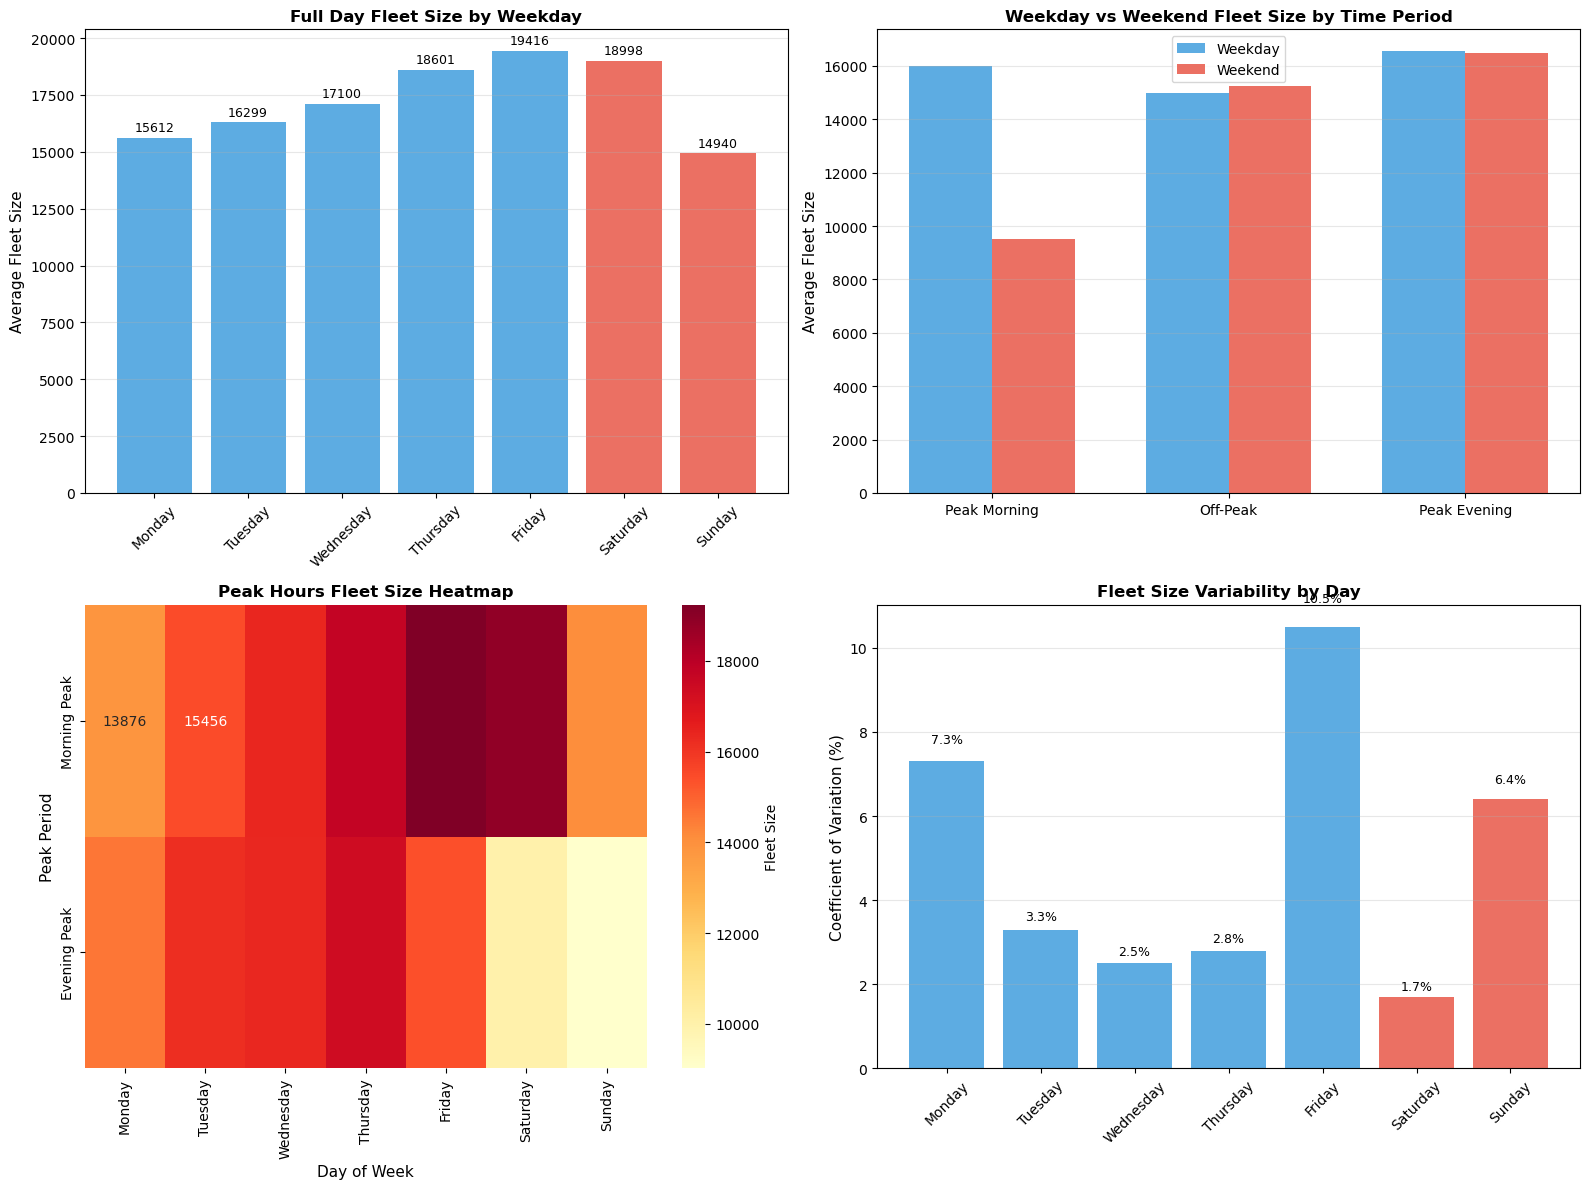

In [6]:
import pandas as pd
import src.fleet_size.visualizations as visualizations
importlib.reload(visualizations)


visualizations.visualize_fleet_size_summary(pd.read_csv('../data/processed/uber_fleet_size_summary.csv'), "Uber")

## Improved summary tables

In [5]:
import src.fleet_size.link_sequential_trips as link_sequential_trips
importlib.reload(link_sequential_trips)

# only use Lyft trips
lyft_trip_data = trip_data[trip_data['company'] == 'Lyft']

lyft_fleet_size_summary = link_sequential_trips.create_fleet_size_summary_table_improved(lyft_trip_data, matrix)
lyft_fleet_size_summary.to_csv('../data/processed/lyft_fleet_size_summary_improved.csv', index=False)
lyft_fleet_size_summary

Processing 2025-02-01...
Finished processing 2025-02-01.
Processing 2025-02-02...
Finished processing 2025-02-02.
Processing 2025-02-03...
Finished processing 2025-02-03.
Processing 2025-02-04...
Finished processing 2025-02-04.
Processing 2025-02-05...
Finished processing 2025-02-05.
Processing 2025-02-06...
Finished processing 2025-02-06.
Processing 2025-02-07...
Finished processing 2025-02-07.
Processing 2025-02-08...
Finished processing 2025-02-08.
Processing 2025-02-09...
Finished processing 2025-02-09.
Processing 2025-02-10...
Finished processing 2025-02-10.
Processing 2025-02-11...
Finished processing 2025-02-11.
Processing 2025-02-12...
Finished processing 2025-02-12.
Processing 2025-02-13...
Finished processing 2025-02-13.
Processing 2025-02-14...
Finished processing 2025-02-14.
Processing 2025-02-15...
Finished processing 2025-02-15.
Processing 2025-02-16...
Finished processing 2025-02-16.
Processing 2025-02-17...
Finished processing 2025-02-17.
Processing 2025-02-18...
Finish

,date,Fleet_Size_Full_Day,Fleet_Size_Peak_Morning,Fleet_Size_Peak_Evening,Fleet_Size_Off_Peak,weekday
0,2025-02-01,11081,3347,6393,4823,Saturday
1,2025-02-02,8967,3046,4847,4594,Sunday
2,2025-02-03,7965,5376,4111,3821,Monday
3,2025-02-04,8727,5341,4653,4064,Tuesday
4,2025-02-05,9977,6034,5256,4523,Wednesday
5,2025-02-06,10710,5830,5693,4873,Thursday
6,2025-02-07,12369,6062,6390,5480,Friday
7,2025-02-08,10900,3661,6295,4910,Saturday
8,2025-02-09,9782,2931,6540,4093,Sunday
9,2025-02-10,8713,5646,4331,4163,Monday


In [6]:
# only use Uber trips
uber_trip_data = trip_data[trip_data['company'] == 'Uber']

uber_fleet_size_summary = link_sequential_trips.create_fleet_size_summary_table_improved(uber_trip_data, matrix)
uber_fleet_size_summary.to_csv('../data/processed/uber_fleet_size_summary_improved.csv', index=False)
uber_fleet_size_summary


Processing 2025-02-01...
Finished processing 2025-02-01.
Processing 2025-02-02...
Finished processing 2025-02-02.
Processing 2025-02-03...
Finished processing 2025-02-03.
Processing 2025-02-04...
Finished processing 2025-02-04.
Processing 2025-02-05...
Finished processing 2025-02-05.
Processing 2025-02-06...
Finished processing 2025-02-06.
Processing 2025-02-07...
Finished processing 2025-02-07.
Processing 2025-02-08...
Finished processing 2025-02-08.
Processing 2025-02-09...
Finished processing 2025-02-09.
Processing 2025-02-10...
Finished processing 2025-02-10.
Processing 2025-02-11...
Finished processing 2025-02-11.
Processing 2025-02-12...
Finished processing 2025-02-12.
Processing 2025-02-13...
Finished processing 2025-02-13.
Processing 2025-02-14...
Finished processing 2025-02-14.
Processing 2025-02-15...
Finished processing 2025-02-15.
Processing 2025-02-16...
Finished processing 2025-02-16.
Processing 2025-02-17...
Finished processing 2025-02-17.
Processing 2025-02-18...
Finish

,date,Fleet_Size_Full_Day,Fleet_Size_Peak_Morning,Fleet_Size_Peak_Evening,Fleet_Size_Off_Peak,weekday
0,2025-02-01,34041,10151,19322,15593,Saturday
1,2025-02-02,24847,9510,14109,14873,Sunday
2,2025-02-03,25279,16193,13336,12618,Monday
3,2025-02-04,28517,16677,15692,14052,Tuesday
4,2025-02-05,30294,16617,16760,15221,Wednesday
5,2025-02-06,31765,18198,16936,15333,Thursday
6,2025-02-07,33055,15670,18845,16858,Friday
7,2025-02-08,32604,10087,18330,15651,Saturday
8,2025-02-09,29034,8691,15517,14748,Sunday
9,2025-02-10,27429,15881,14936,14316,Monday


## Comparative Analysis of Uber and Lyft

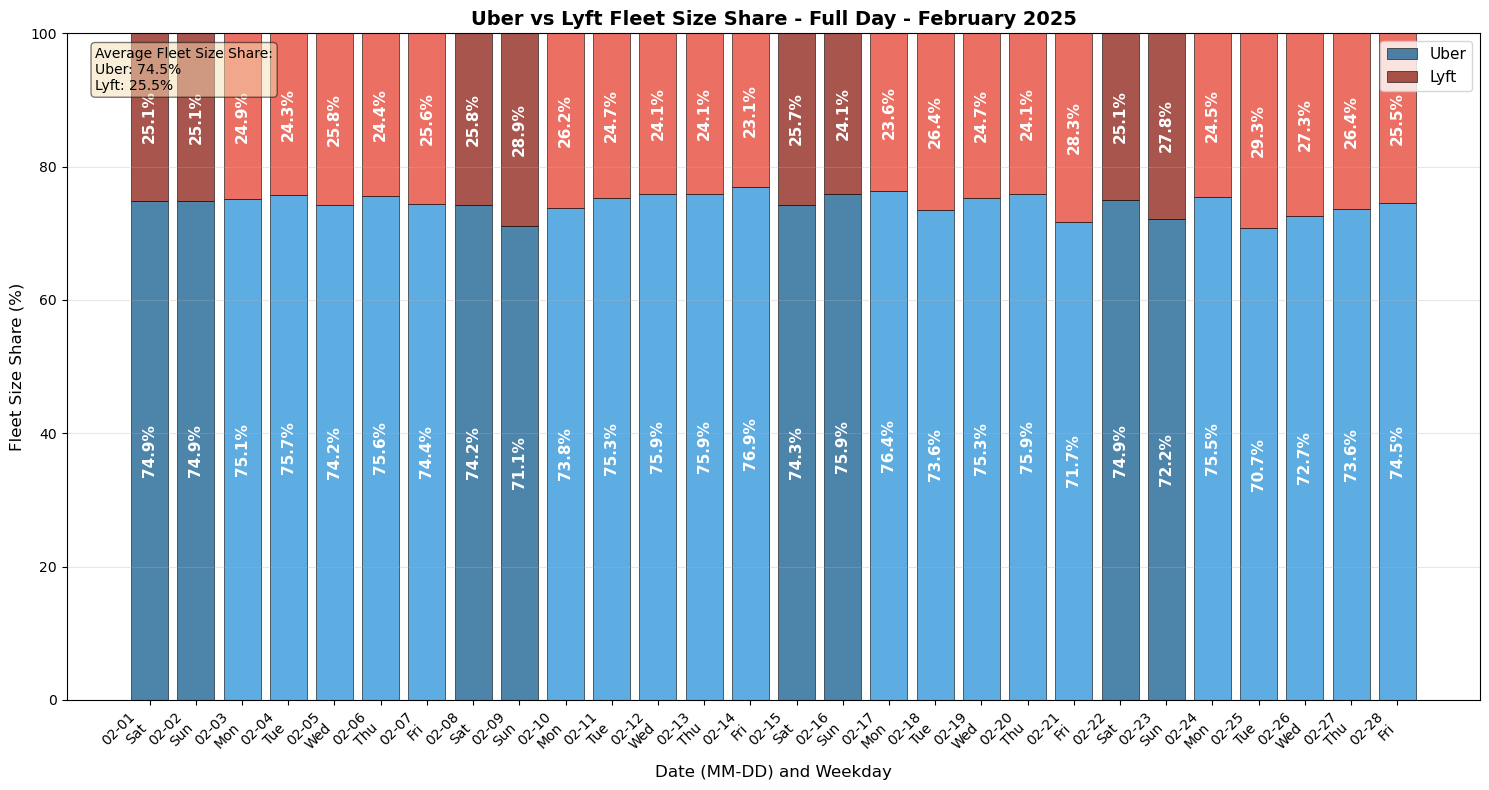


=== Fleet Size Share Analysis - Full Day ===
Average Uber fleet size share: 74.5%
Average Lyft fleet size share: 25.5%
Uber fleet size share range: 70.7% - 76.9%
Lyft fleet size share range: 23.1% - 29.3%


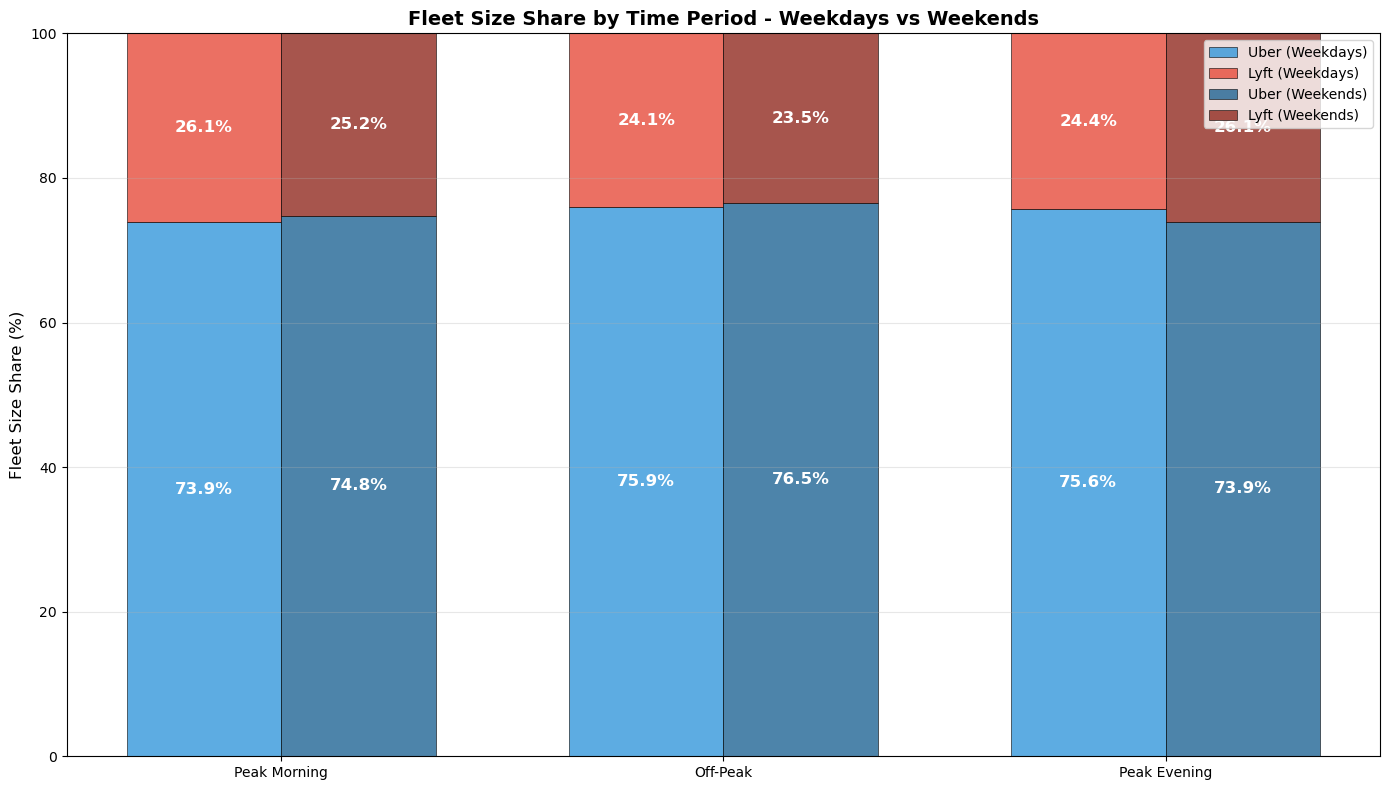


=== Fleet Size Share Analysis by Time Period ===

Weekdays:
Peak Morning: Uber 73.9%, Lyft 26.1%
Off-Peak: Uber 75.9%, Lyft 24.1%
Peak Evening: Uber 75.6%, Lyft 24.4%

Weekends:
Peak Morning: Uber 74.8%, Lyft 25.2%
Off-Peak: Uber 76.5%, Lyft 23.5%
Peak Evening: Uber 73.9%, Lyft 26.1%


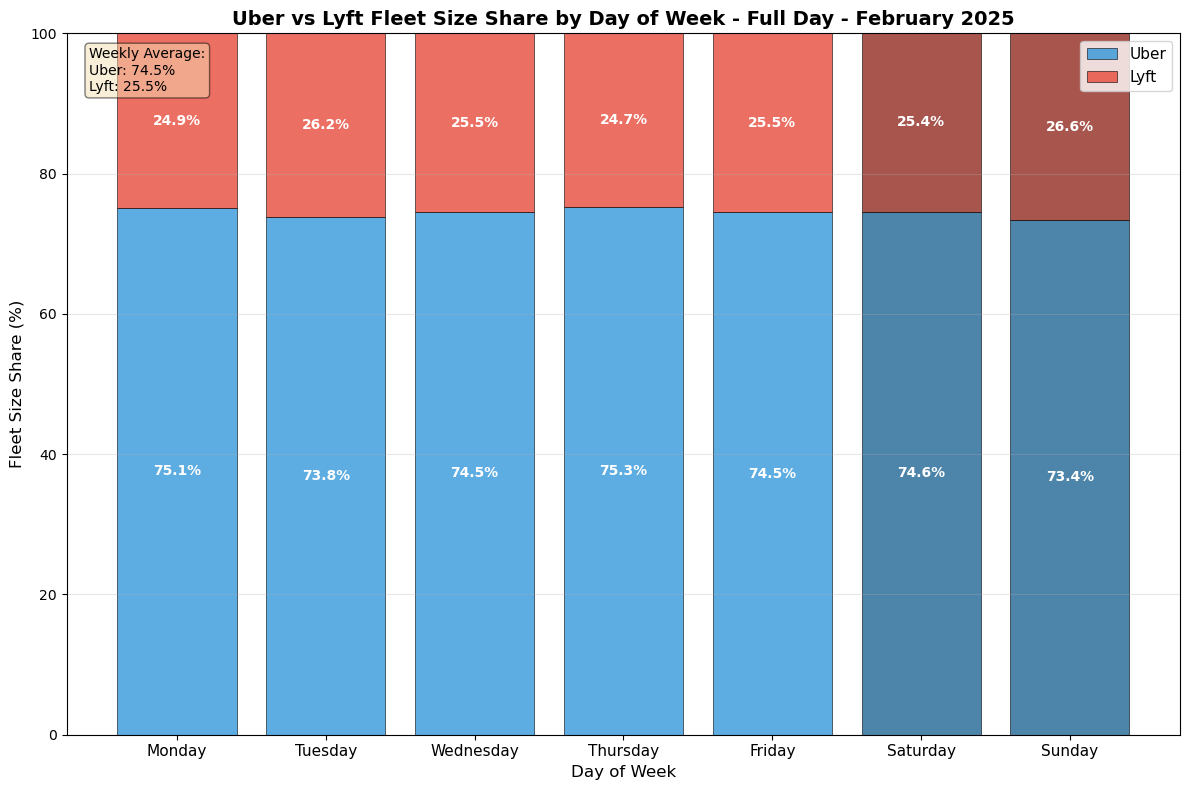


=== Fleet Size Share Analysis by Day of Week - Full Day ===
Monday: Uber 75.1%, Lyft 24.9%
Tuesday: Uber 73.8%, Lyft 26.2%
Wednesday: Uber 74.5%, Lyft 25.5%
Thursday: Uber 75.3%, Lyft 24.7%
Friday: Uber 74.5%, Lyft 25.5%
Saturday: Uber 74.6%, Lyft 25.4%
Sunday: Uber 73.4%, Lyft 26.6%

Weekly Average: Uber 74.5%, Lyft 25.5%


In [5]:
import pandas as pd
import src.fleet_size.comparative_analysis as comparative_analysis
importlib.reload(comparative_analysis)

uber_fleet_size_summary = pd.read_csv('../data/processed/uber_fleet_size_summary.csv')
lyft_fleet_size_summary = pd.read_csv('../data/processed/lyft_fleet_size_summary.csv')

comparative_analysis.visualize_fleet_size_share_stacked(uber_fleet_size_summary, lyft_fleet_size_summary)
comparative_analysis.visualize_fleet_size_share_time_periods(uber_fleet_size_summary, lyft_fleet_size_summary)
comparative_analysis.visualize_fleet_size_share_by_weekday(uber_fleet_size_summary, lyft_fleet_size_summary)

## Fleet size over time

Date range: 2025-02-25 00:00:00 to 2025-02-26 00:00:00
Total trips before filtering: 4919838
Filtered trips: 161919
Total drivers on 2025-02-25: 9913
driver_start_times: ['2025-02-25T09:01:25.000000' '2025-02-25T08:53:53.000000'
 '2025-02-25T08:47:16.000000' ... '2025-02-25T07:35:27.000000'
 '2025-02-25T08:00:37.000000' '2025-02-25T07:26:40.000000']
driver_end_times: ['2025-02-26T00:17:06.000000' '2025-02-25T23:56:54.000000'
 '2025-02-25T23:35:36.000000' ... '2025-02-26T00:05:36.000000'
 '2025-02-26T00:16:47.000000' '2025-02-26T00:09:54.000000']


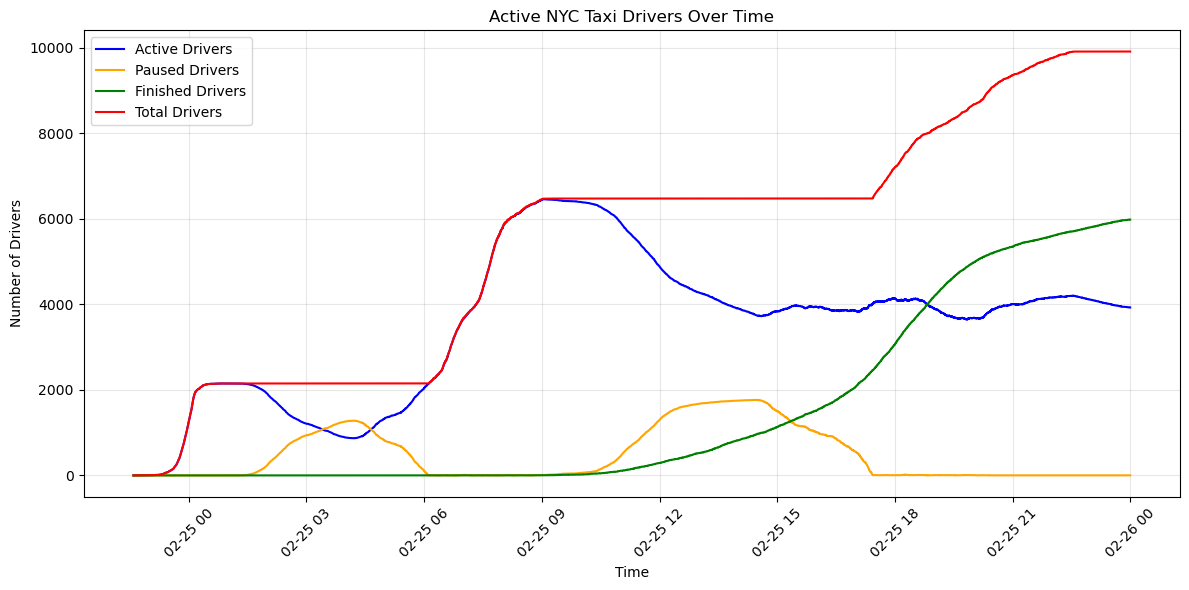

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
import src.fleet_size.active_drivers as active_drivers
importlib.reload(active_drivers)
from src.fleet_size.active_drivers import calculate_fleet_size_over_time, active_drivers_per_minute, visualize_active_drivers

# only use Lyft trips
lyft_trip_data = trip_data[trip_data['company'] == 'Lyft']

all_start_times, all_end_times, driver_count, drivers_df = calculate_fleet_size_over_time(lyft_trip_data, matrix, target_date='2025-02-25')
print(f"Total drivers on 2025-02-25: {driver_count}")
print(f"driver_start_times: {all_start_times}")
print(f"driver_end_times: {all_end_times}")


visualize_active_drivers(drivers_df)

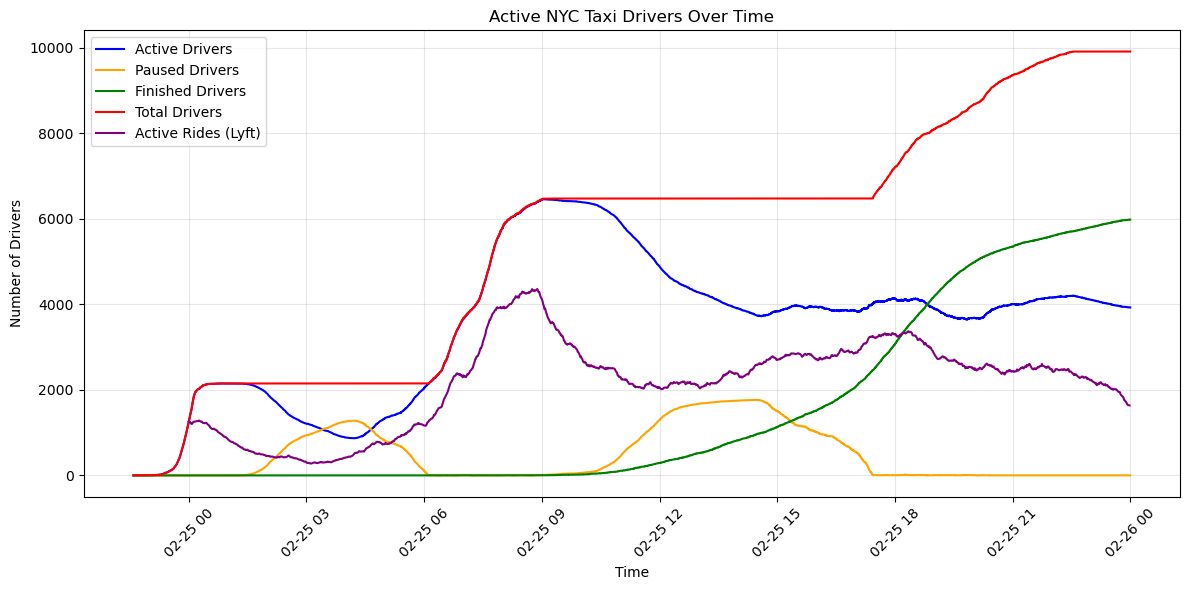

<Figure size 640x480 with 0 Axes>

In [12]:
import importlib

import src.fleet_size.active_trips as active_trips
importlib.reload(active_trips)

import src.fleet_size.active_drivers as active_drivers
importlib.reload(active_drivers)
from src.fleet_size.active_drivers import visualize_active_drivers
from src.fleet_size.active_trips import calculate_active_rides_per_minute

active_trips_lyft = calculate_active_rides_per_minute(lyft_trip_data, target_date='2025-02-25')

visualize_active_drivers(drivers_df, active_trips_lyft)


In [ ]:
active_trips_lyft



{'Lyft':                 datetime  active_rides  hour  minute time_of_day
 0    2025-02-25 00:00:00          1267     0       0       00:00
 1    2025-02-25 00:01:00          1248     0       1       00:01
 2    2025-02-25 00:02:00          1247     0       2       00:02
 3    2025-02-25 00:03:00          1219     0       3       00:03
 4    2025-02-25 00:04:00          1205     0       4       00:04
 ...                  ...           ...   ...     ...         ...
 1435 2025-02-25 23:55:00          1680    23      55       23:55
 1436 2025-02-25 23:56:00          1654    23      56       23:56
 1437 2025-02-25 23:57:00          1643    23      57       23:57
 1438 2025-02-25 23:58:00          1640    23      58       23:58
 1439 2025-02-25 23:59:00          1638    23      59       23:59
 
 [1440 rows x 5 columns]}